### Force field - one component

#### Small molecule

Reading data	0.69 s
Preparing input	5.26 s


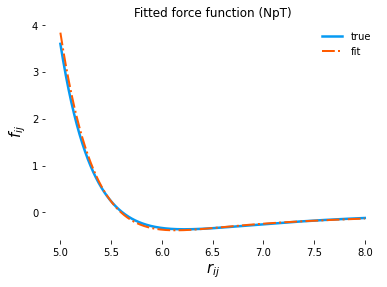

In [1]:
import numpy as np
from trajectory_matching import TrajectoryMatching
from misc import plot_1component

x = np.linspace(5, 8, 1000)

def target_function(x):
    return 24 * 0.75 / x * (2 * (5/x) ** 12 - (5/x) ** 6)

def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/one_component_files/lj_trajectory_match_npt.out"
params = range(0, -15, -1)
simulation_timestep = 0.5
# These parameters affect the accuracy of the fit. 'steps' = {'NVE': 2/500, 'NpT': 5/500}
steps = 5
timesteps_in_fit = 500

proc = TrajectoryMatching(outfile_path=outfile, simulation_timestep=simulation_timestep, cutoff=15,
                      basis=basis_function, basis_parameters=params,
                      evrey_n_from_output=steps, timesteps_in_fit=timesteps_in_fit)

proc.prepare_training_data()
proc.regress(method='bayesian')

y_fit = proc.predict(x)[0]
y = target_function(x)
plot_1component(x, y, y_fit)

#### Heavy molecule

Reading data	1.12 s
Preparing input	5.69 s


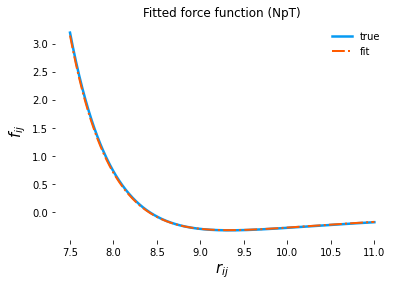

In [2]:
import numpy as np
from trajectory_matching import TrajectoryMatching
from misc import plot_1component

x = np.linspace(7.5, 11, 1000)

def target_function(x):
    return 24 * 1.0 / x * (2 * (7.5/x) ** 12 - (7.5/x) ** 6)

def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/one_component_files/lj_trajectory_match_heavy_npt.out"
params = range(0, -15, -1)
simulation_timestep = 0.5
# These parameters affect the accuracy of the fit. 'steps' = {'NVE': 3/400, 'NpT': 7/400}
steps = 7
timesteps_in_fit = 400

proc = TrajectoryMatching(outfile_path=outfile, simulation_timestep=simulation_timestep, cutoff=15,
                      basis=basis_function, basis_parameters=params,
                      evrey_n_from_output=steps, timesteps_in_fit=timesteps_in_fit)

proc.prepare_training_data()
proc.regress(method='bayesian')

y_fit = proc.predict(x)[0]
y = target_function(x)
plot_1component(x, y, y_fit)

### Force field - multi-component

Reading data	1.85 s
Preparing input	51.11 s


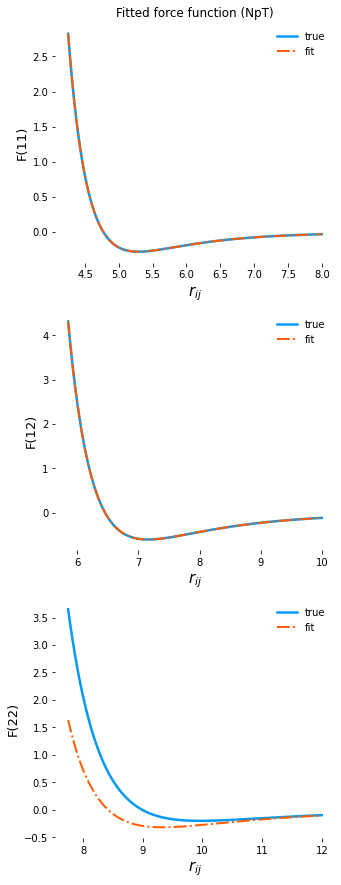

In [3]:
import numpy as np
from trajectory_matching import TrajectoryMatching
from misc import plot_2component


X = [np.linspace(4.25, 8, 1000), np.linspace(5.85, 10, 1000), np.linspace(7.75, 12, 1000)]

def target_function0(x):
    return 24 * 0.50 / x * (2 * (4.25/x) ** 12 - (4.25/x) ** 6)

def target_function1(x):
    return 24 * 1.45 / x * (2 * (5.75/x) ** 12 - (5.75/x) ** 6)

def target_function2(x):
    return 24 * 1.00 / x * (2 * (7.75/x) ** 12 - (7.5/x) ** 6)

def basis_function(x, p):
    return np.sign(x) * np.abs(x) ** p

outfile = "/home/markjenei/polymerisation-coarse-graining/lj_test/two_component_files/lj_trajectory_match_npt.out"
params = range(0, -14, -2)
simulation_timestep = 0.5
# These parameters affect the accuracy of the fit. 'steps' = {'NVE': 2/75, 'NpT': 2/150}
steps = 2
timesteps_in_fit = 150

proc = TrajectoryMatching(outfile_path=outfile, simulation_timestep=simulation_timestep, cutoff=15,
                      basis=basis_function, basis_parameters=params,
                      evrey_n_from_output=steps, timesteps_in_fit=timesteps_in_fit)

proc.prepare_training_data()
proc.regress(method='bayesian')

Y = [target_function0(X[0]), target_function1(X[1]), target_function2(X[2])]
Y_fit = [proc.predict(X[0])[0], proc.predict(X[1])[1], proc.predict(X[2])[2]]
plot_2component(X, Y, Y_fit)